### Convolutional Neural Networks

In this notebook, we will train a CNN to classify images from CIFA-10 Website. This database is present in the torch library. 
The images in this database are small color images that fall innto one of 10 classes; 

In [1]:
import torch
import numpy as np

# check if CUDA is available

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
else:
    print('CUDA is available! Training on GPU')

CUDA is not available. Training on CPU...


### Load the data

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocess to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile','bird','cat','deer',
          'dog','frog','horse','ship','truck']

Files already downloaded and verified
Files already downloaded and verified


In [3]:
## visualize a batch of training data
import matplotlib.pyplot as plt
%matplotlib inline

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    plt.imshow(np.transpose(img, (1,2,0)))

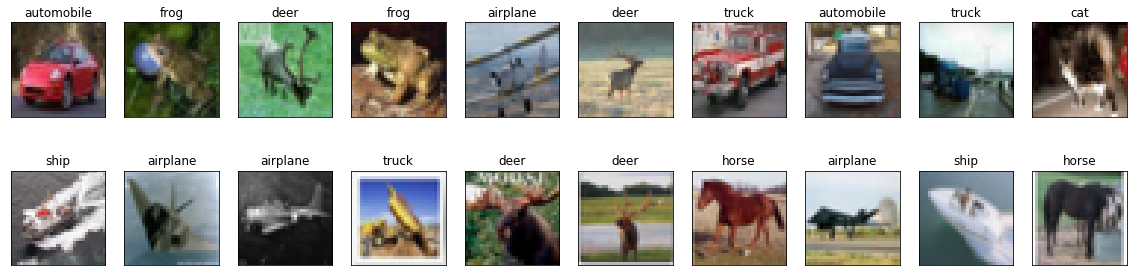

In [4]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20,5))

for index in range(20):
    # add subplot parameters meaning, 1st parameter is the number of rows
    # second parameter = number of columns
    # third parameter is the increment
    ax = fig.add_subplot(2, 20/2, index + 1, xticks=[], yticks=[])
    imshow(images[index])
    ax.set_title(classes[labels[index]])

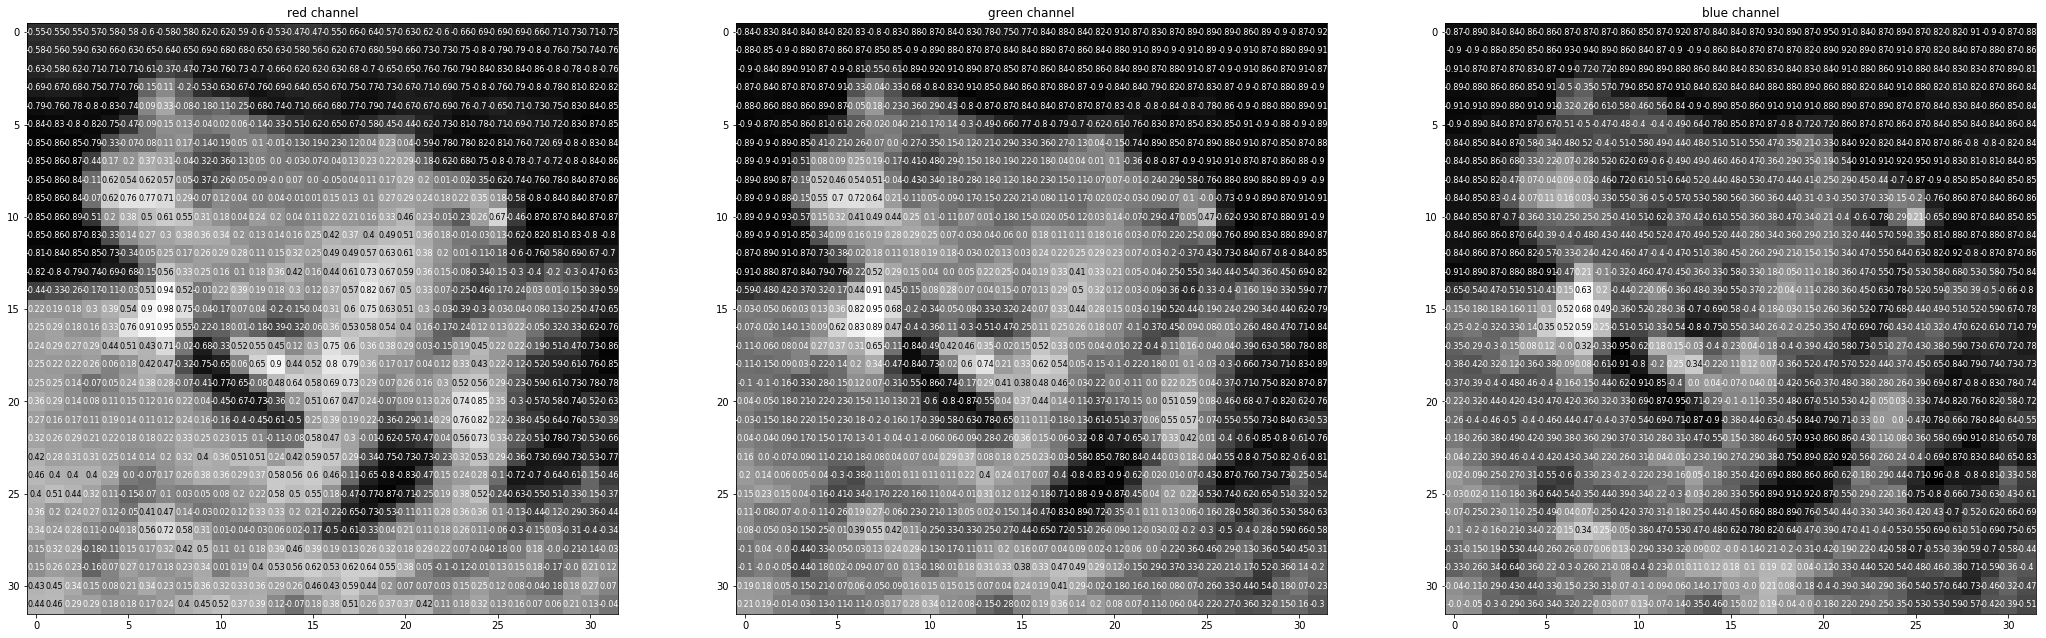

In [5]:
## View an image in more detail
# here we look at the normalize red, green and blue color channels as 3 separate, grayscale intensity images
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']
 
fig = plt.figure(figsize=(36,36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1,3, idx+1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                       horizontalalignment='center',
                       verticalalignment='center', size= 8,
                       color='white' if img[x][y] < thresh else 'black')

### Define the network architecture
This time we will define a CNN architecture. Instead of an MLP which uses Linear, fully connected layers, we will use the following.
1. Convolutional layers, which can be thought of as a stack of filtered images
2. Maxpooling layers which reduces the dimesnions of an input. Keeping only the most active pixels from the previous layers
3. Usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output



In [6]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture. 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # given image size is 32 x 32 x 3
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        # second layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        # third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        ## apply maxpooling layers. It will reduce the output size of the images
        self.pool = nn.MaxPool2d(2,2) 
        # Linear layer
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # Linear layer
        self.fc2 = nn.Linear(500, 10)
        # Add dropout layer
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        # add sequence of convolutional layers and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add first hidden layer with relu activation functions
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25)
)


In [7]:
import torch.optim as optim

## loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.721651 	Validation Loss: 0.373179
Validation loss decreased (inf --> 0.373179).  Saving model ...
Epoch: 2 	Training Loss: 1.369971 	Validation Loss: 0.317865
Validation loss decreased (0.373179 --> 0.317865).  Saving model ...
Epoch: 3 	Training Loss: 1.212184 	Validation Loss: 0.285387
Validation loss decreased (0.317865 --> 0.285387).  Saving model ...
Epoch: 4 	Training Loss: 1.118991 	Validation Loss: 0.264984
Validation loss decreased (0.285387 --> 0.264984).  Saving model ...
Epoch: 5 	Training Loss: 1.039252 	Validation Loss: 0.252877
Validation loss decreased (0.264984 --> 0.252877).  Saving model ...
Epoch: 6 	Training Loss: 0.968033 	Validation Loss: 0.229662
Validation loss decreased (0.252877 --> 0.229662).  Saving model ...
Epoch: 7 	Training Loss: 0.912059 	Validation Loss: 0.215981
Validation loss decreased (0.229662 --> 0.215981).  Saving model ...
Epoch: 8 	Training Loss: 0.860904 	Validation Loss: 0.210294
Validation loss decreased (0.21598

In [9]:
model.load_state_dict(torch.load('model_cifar.pt'))


In [10]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.732358

Test Accuracy of airplane: 77% (770/1000)
Test Accuracy of automobile: 85% (855/1000)
Test Accuracy of  bird: 65% (654/1000)
Test Accuracy of   cat: 50% (500/1000)
Test Accuracy of  deer: 72% (728/1000)
Test Accuracy of   dog: 67% (670/1000)
Test Accuracy of  frog: 85% (850/1000)
Test Accuracy of horse: 77% (777/1000)
Test Accuracy of  ship: 88% (888/1000)
Test Accuracy of truck: 82% (820/1000)

Test Accuracy (Overall): 75% (7512/10000)


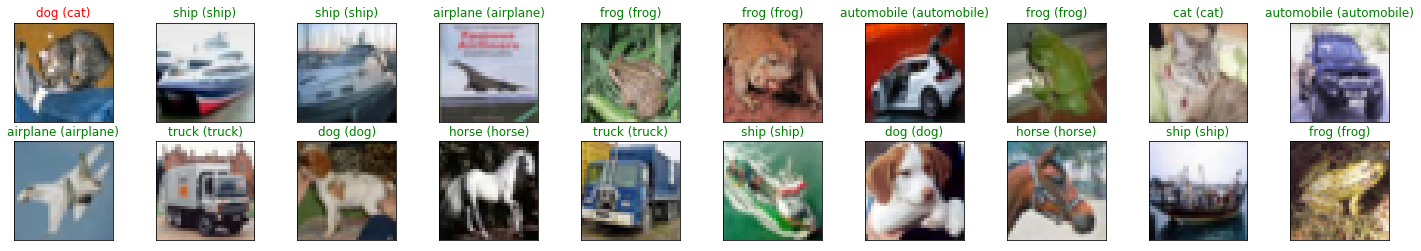

In [11]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))